# Predictive Analytics: Entity Reaction Profiler

**Model 1**: Given a topic/entity as input → Predict Trump's emotional reaction

This notebook builds entity reaction profiles by analyzing:
- Average sentiment when an entity is mentioned
- Dominant emotions triggered by each entity
- Rhetorical intensity patterns
- Emotional volatility (how erratic reactions are)

**Output**: A predictive model that can estimate Trump's reaction to any topic.


In [1]:
%pip install matplotlib
%pip install seaborn

import pandas as pd
import numpy as np
import json
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Libraries loaded successfully!


## 1. Load Data


In [2]:
# Load speech features
features_dir = Path('../data/transformed')
features_files = list(features_dir.glob('speeches_features_complete_*.csv'))

if features_files:
    latest_features = max(features_files, key=lambda p: p.stat().st_mtime)
    df_features = pd.read_csv(latest_features)
    print(f"Loaded features: {len(df_features)} speeches, {len(df_features.columns)} features")
else:
    print("ERROR: No feature files found!")

# Load entity catalog
entities_dir = Path('../data/entities')
entity_files = list(entities_dir.glob('entity_catalog_*.json'))

if entity_files:
    latest_entity = max(entity_files, key=lambda p: p.stat().st_mtime)
    with open(latest_entity, 'r', encoding='utf-8') as f:
        entity_catalog = json.load(f)
    print(f"Loaded entity catalog: {entity_catalog['total_entities']} entities")

# Load entity relationships (for speech-entity mapping)
relationship_files = list(entities_dir.glob('entity_relationships_*.json'))

if relationship_files:
    latest_rel = max(relationship_files, key=lambda p: p.stat().st_mtime)
    with open(latest_rel, 'r', encoding='utf-8') as f:
        entity_relationships = json.load(f)
    print(f"Loaded relationships: {entity_relationships['statistics']['total_entities']} entities across {entity_relationships['statistics']['total_speeches']} speeches")


Loaded features: 43 speeches, 99 features
Loaded entity catalog: 2872 entities
Loaded relationships: 2872 entities across 43 speeches


In [4]:
# ============================================
# DEBUG: Check what data we actually have
# ============================================

print("=" * 60)
print("DIAGNOSTIC: Checking feature data quality")
print("=" * 60)

# 1. What columns exist?
print("\n1. COLUMNS IN df_features:")
print(f"   Total columns: {len(df_features.columns)}")
sentiment_cols = [c for c in df_features.columns if 'sentiment' in c.lower()]
emotion_cols = [c for c in df_features.columns if 'emotion' in c.lower()]
print(f"   Sentiment columns: {sentiment_cols}")
print(f"   Emotion columns: {emotion_cols}")

# 2. Check sentiment_compound values
print("\n2. SENTIMENT_COMPOUND VALUES:")
if 'sentiment_compound' in df_features.columns:
    print(f"   Min: {df_features['sentiment_compound'].min()}")
    print(f"   Max: {df_features['sentiment_compound'].max()}")
    print(f"   Mean: {df_features['sentiment_compound'].mean():.3f}")
    print(f"   Null count: {df_features['sentiment_compound'].isna().sum()}")
    print(f"   Sample values: {df_features['sentiment_compound'].head(10).tolist()}")
else:
    print("   ❌ sentiment_compound column NOT FOUND!")

# 3. Check emotion columns
print("\n3. EMOTION COLUMN VALUES:")
for col in ['emotion_anger', 'emotion_joy', 'emotion_fear', 'emotion_trust']:
    if col in df_features.columns:
        print(f"   {col}: min={df_features[col].min()}, max={df_features[col].max()}, mean={df_features[col].mean():.3f}, nulls={df_features[col].isna().sum()}")
    else:
        print(f"   ❌ {col} NOT FOUND!")

# 4. Check speech_id values
print("\n4. SPEECH IDS:")
feature_speech_ids = set(df_features['speech_id'].tolist())
print(f"   Speech IDs in features: {len(feature_speech_ids)}")
print(f"   Sample IDs: {list(feature_speech_ids)[:5]}")

# 5. Show a sample row
print("\n5. SAMPLE ROW FROM df_features:")
sample_cols = ['speech_id', 'sentiment_compound'] + emotion_cols[:4]
sample_cols = [c for c in sample_cols if c in df_features.columns]
print(df_features[sample_cols].head(3).to_string())


DIAGNOSTIC: Checking feature data quality

1. COLUMNS IN df_features:
   Total columns: 99
   Sentiment columns: ['sentiment_neg', 'sentiment_neu', 'sentiment_pos', 'sentiment_compound', 'sentiment_mean', 'sentiment_variance', 'sentiment_std', 'sentiment_max', 'sentiment_min', 'sentiment_range']
   Emotion columns: ['emotion_anger', 'emotion_fear', 'emotion_joy', 'emotion_sadness', 'emotion_surprise', 'emotion_disgust', 'emotion_trust', 'emotion_anticipation', 'dominant_emotion', 'dominant_emotion_score']

2. SENTIMENT_COMPOUND VALUES:
   Min: -0.9997
   Max: 1.0
   Mean: 0.952
   Null count: 0
   Sample values: [0.9999, 1.0, 0.9999, 1.0, 1.0, 0.9998, 1.0, 1.0, 1.0, 1.0]

3. EMOTION COLUMN VALUES:
   emotion_anger: min=0, max=0, mean=0.000, nulls=0
   emotion_joy: min=0, max=0, mean=0.000, nulls=0
   emotion_fear: min=0, max=0, mean=0.000, nulls=0
   emotion_trust: min=0, max=0, mean=0.000, nulls=0

4. SPEECH IDS:
   Speech IDs in features: 43
   Sample IDs: ['_trump-speaks-to-republic

## 1b. Fix Missing Emotion Data

The emotion columns are all zeros because the transformation pipeline didn't compute them.  
Let's compute emotions directly from the cleaned text using keyword matching.


In [5]:
# Load cleaned speeches to get the text
cleaned_dir = Path('../data/cleaned')
cleaned_files = list(cleaned_dir.glob('speeches_cleaned_*.json'))

if cleaned_files:
    latest_cleaned = max(cleaned_files, key=lambda p: p.stat().st_mtime)
    with open(latest_cleaned, 'r', encoding='utf-8') as f:
        cleaned_speeches = json.load(f)
    print(f"Loaded {len(cleaned_speeches)} cleaned speeches for emotion analysis")
    
    # Create speech_id -> text mapping
    speech_texts = {}
    for speech in cleaned_speeches:
        sid = speech.get('speech_id', '')
        text = speech.get('cleaned_text', speech.get('text', ''))
        if sid and text:
            speech_texts[sid] = text.lower()
    print(f"Mapped {len(speech_texts)} speech texts")
else:
    print("ERROR: No cleaned speech files found!")


Loaded 43 cleaned speeches for emotion analysis
Mapped 43 speech texts


In [6]:
# Simple emotion lexicon (based on NRC categories)
EMOTION_LEXICON = {
    'anger': ['angry', 'furious', 'outraged', 'mad', 'hate', 'hatred', 'rage', 'hostile', 
              'bitter', 'resentment', 'disgrace', 'terrible', 'horrible', 'disaster', 
              'corrupt', 'crooked', 'liar', 'liars', 'enemy', 'enemies', 'destroy', 
              'destroyed', 'attack', 'attacked', 'fight', 'fought', 'war', 'kill'],
    'fear': ['afraid', 'scared', 'fear', 'terror', 'threat', 'danger', 'dangerous', 
             'risk', 'worry', 'worried', 'anxious', 'panic', 'horror', 'dread',
             'invasion', 'crime', 'criminal', 'criminals', 'violence', 'violent'],
    'joy': ['happy', 'joy', 'love', 'wonderful', 'great', 'amazing', 'fantastic', 
            'beautiful', 'excellent', 'incredible', 'tremendous', 'success', 'successful',
            'win', 'won', 'winner', 'winners', 'best', 'proud', 'celebrate', 'celebration'],
    'sadness': ['sad', 'sorry', 'loss', 'lost', 'tragic', 'tragedy', 'unfortunate', 
                'disappointed', 'disappointment', 'grief', 'misery', 'suffering', 'pain'],
    'surprise': ['surprised', 'shocking', 'shocked', 'unexpected', 'amazing', 'incredible',
                 'unbelievable', 'stunning', 'astonishing', 'remarkable'],
    'disgust': ['disgusting', 'disgrace', 'shameful', 'shame', 'pathetic', 'weak', 
                'loser', 'losers', 'fake', 'fraud', 'scam', 'corrupt', 'corruption', 
                'swamp', 'drain', 'nasty', 'horrible', 'terrible', 'worst'],
    'trust': ['trust', 'believe', 'faith', 'honest', 'true', 'truth', 'loyal', 'loyalty',
              'reliable', 'dependable', 'promise', 'commitment', 'dedicated', 'patriot',
              'america', 'american', 'americans', 'country', 'nation', 'freedom', 'liberty'],
    'anticipation': ['will', 'going to', 'plan', 'future', 'hope', 'expect', 'looking forward',
                     'soon', 'tomorrow', 'next', 'coming', 'goal', 'goals', 'agenda']
}

def compute_emotions_from_text(text):
    """Compute emotion scores from text using keyword matching"""
    text_lower = text.lower()
    word_count = len(text_lower.split())
    
    if word_count == 0:
        return {emotion: 0.0 for emotion in EMOTION_LEXICON}
    
    scores = {}
    for emotion, keywords in EMOTION_LEXICON.items():
        count = 0
        for keyword in keywords:
            # Count occurrences (simple word boundary match)
            import re
            pattern = r'\b' + re.escape(keyword) + r'\b'
            count += len(re.findall(pattern, text_lower))
        
        # Normalize by word count (per 1000 words)
        scores[emotion] = (count / word_count) * 1000
    
    return scores

# Test on first speech
if speech_texts:
    sample_id = list(speech_texts.keys())[0]
    sample_emotions = compute_emotions_from_text(speech_texts[sample_id])
    print(f"Sample emotion scores for '{sample_id}':")
    for emotion, score in sorted(sample_emotions.items(), key=lambda x: -x[1]):
        print(f"  {emotion}: {score:.2f}")


Sample emotion scores for '_rutte-and-trump-at-white-house':
  anticipation: 12.11
  trust: 6.70
  joy: 6.05
  anger: 5.80
  disgust: 1.93
  fear: 1.16
  surprise: 0.64
  sadness: 0.52


In [7]:
# Update df_features with computed emotions
print("Computing emotions for all speeches...")

for idx, row in df_features.iterrows():
    speech_id = row['speech_id']
    
    if speech_id in speech_texts:
        emotions = compute_emotions_from_text(speech_texts[speech_id])
        
        # Update emotion columns
        for emotion, score in emotions.items():
            col_name = f'emotion_{emotion}'
            if col_name in df_features.columns:
                df_features.at[idx, col_name] = score
        
        # Update dominant emotion
        max_emotion = max(emotions.items(), key=lambda x: x[1])
        df_features.at[idx, 'dominant_emotion'] = max_emotion[0]
        df_features.at[idx, 'dominant_emotion_score'] = max_emotion[1]

# Verify the fix
print("\n✓ Emotions computed! Verifying...")
print("\nEMOTION COLUMN VALUES (after fix):")
for col in ['emotion_anger', 'emotion_joy', 'emotion_fear', 'emotion_trust', 'emotion_disgust']:
    if col in df_features.columns:
        print(f"   {col}: min={df_features[col].min():.2f}, max={df_features[col].max():.2f}, mean={df_features[col].mean():.2f}")

# Show dominant emotions distribution
print("\nDOMINANT EMOTION DISTRIBUTION:")
print(df_features['dominant_emotion'].value_counts())


Computing emotions for all speeches...

✓ Emotions computed! Verifying...

EMOTION COLUMN VALUES (after fix):
   emotion_anger: min=0.00, max=9.76, mean=3.62
   emotion_joy: min=3.56, max=19.67, mean=9.14
   emotion_fear: min=0.00, max=5.67, mean=1.46
   emotion_trust: min=2.01, max=13.50, mean=6.21
   emotion_disgust: min=0.00, max=3.86, mean=1.33

DOMINANT EMOTION DISTRIBUTION:
dominant_emotion
anticipation    31
joy             10
trust            2
Name: count, dtype: int64


In [8]:
# IMPORTANT: Recreate the speech_features lookup with fixed emotion data
speech_features = df_features.set_index('speech_id').to_dict('index')
print(f"✓ Rebuilt speech_features lookup with {len(speech_features)} speeches (now with emotions!)")


✓ Rebuilt speech_features lookup with 43 speeches (now with emotions!)


## 2. Build Entity-to-Speech Mapping


In [9]:
# Get entity-to-speech mapping from relationships
entity_speech_map = entity_relationships.get('entity_speech_map', {})

print(f"Total entities with speech mappings: {len(entity_speech_map)}")

# NOTE: speech_features was already created in Cell 9 with fixed emotions
# Re-create here to ensure we have the latest data with emotions
speech_features = df_features.set_index('speech_id').to_dict('index')
print(f"Speech features indexed: {len(speech_features)} speeches")

# Verify emotions are present
sample_id = list(speech_features.keys())[0]
sample_anger = speech_features[sample_id].get('emotion_anger', 'NOT FOUND')
sample_joy = speech_features[sample_id].get('emotion_joy', 'NOT FOUND')
print(f"  ✓ Emotion check - anger: {sample_anger:.2f}, joy: {sample_joy:.2f}" if isinstance(sample_anger, (int, float)) else f"  ⚠️ Emotions missing: {sample_anger}")

# Preview a few mappings
sample_entities = list(entity_speech_map.keys())[:5]
for entity in sample_entities:
    speeches = entity_speech_map[entity]
    print(f"  {entity}: appears in {len(speeches)} speeches")


Total entities with speech mappings: 2872
Speech features indexed: 43 speeches
  ✓ Emotion check - anger: 5.80, joy: 6.05
  PERSON:Donald Trump: appears in 35 speeches
  PERSON:Mark Rutte: appears in 5 speeches
  PERSON:Mark: appears in 9 speeches
  PERSON:Putin: appears in 28 speeches
  PERSON:Xi: appears in 17 speeches


## 3. Compute Entity Reaction Profiles


In [10]:
def compute_entity_reaction_profile(entity_key, speech_ids, speech_features):
    """
    Compute reaction profile for a single entity.
    
    Returns dict with:
    - sentiment metrics (avg, std, min, max)
    - emotion averages
    - rhetorical metrics
    - volatility score
    """
    # Filter to speeches that exist in our features
    valid_speech_ids = [sid for sid in speech_ids if sid in speech_features]
    
    if len(valid_speech_ids) == 0:
        return None
    
    # Collect metrics from speeches
    sentiments = []
    emotions = defaultdict(list)
    rhetoricals = defaultdict(list)
    
    emotion_cols = ['emotion_anger', 'emotion_fear', 'emotion_joy', 'emotion_sadness', 
                    'emotion_surprise', 'emotion_disgust', 'emotion_trust', 'emotion_anticipation']
    rhetorical_cols = ['anaphora_total', 'contrast_markers', 'repetition_density', 
                       'alliteration_count', 'superlative_count', 'question_count', 'exclamation_count']
    
    for sid in valid_speech_ids:
        features = speech_features[sid]
        
        # Sentiment
        if 'sentiment_compound' in features and pd.notna(features['sentiment_compound']):
            sentiments.append(features['sentiment_compound'])
        
        # Emotions
        for col in emotion_cols:
            if col in features and pd.notna(features[col]):
                emotions[col].append(features[col])
        
        # Rhetorical
        for col in rhetorical_cols:
            if col in features and pd.notna(features[col]):
                rhetoricals[col].append(features[col])
    
    if len(sentiments) == 0:
        return None
    
    # Parse entity key
    if ':' in entity_key:
        entity_type, entity_name = entity_key.split(':', 1)
    else:
        entity_type = 'UNKNOWN'
        entity_name = entity_key
    
    # Build profile
    profile = {
        'entity_key': entity_key,
        'entity_name': entity_name,
        'entity_type': entity_type,
        'speech_count': len(valid_speech_ids),
        
        # Sentiment metrics
        'avg_sentiment': np.mean(sentiments),
        'std_sentiment': np.std(sentiments) if len(sentiments) > 1 else 0,
        'min_sentiment': np.min(sentiments),
        'max_sentiment': np.max(sentiments),
        'sentiment_range': np.max(sentiments) - np.min(sentiments),
        
        # Volatility (high std = erratic reactions)
        'volatility': np.std(sentiments) if len(sentiments) > 1 else 0,
    }
    
    # Emotion averages
    for col in emotion_cols:
        col_short = col.replace('emotion_', '')
        profile[f'avg_{col_short}'] = np.mean(emotions[col]) if emotions[col] else 0
    
    # Find dominant emotion
    emotion_avgs = {col.replace('emotion_', ''): np.mean(emotions[col]) if emotions[col] else 0 
                    for col in emotion_cols}
    max_emotion = max(emotion_avgs, key=emotion_avgs.get)
    max_score = emotion_avgs[max_emotion]
    
    # If all emotion scores are zero, treat as no dominant emotion
    if max_score == 0:
        profile['dominant_emotion'] = 'none'
        profile['dominant_emotion_score'] = 0
    else:
        profile['dominant_emotion'] = max_emotion
        profile['dominant_emotion_score'] = max_score
    
    # Rhetorical averages
    for col in rhetorical_cols:
        profile[f'avg_{col}'] = np.mean(rhetoricals[col]) if rhetoricals[col] else 0
    
    # Compute rhetorical intensity score (normalized composite)
    rhetorical_scores = [profile.get(f'avg_{col}', 0) for col in rhetorical_cols]
    profile['rhetorical_intensity'] = np.mean(rhetorical_scores) if rhetorical_scores else 0
    
    return profile

print("Profile computation function defined!")


Profile computation function defined!


In [11]:
# Compute profiles for all entities
print("Computing entity reaction profiles...")

entity_profiles = []
skipped = 0

for entity_key, speech_ids in entity_speech_map.items():
    profile = compute_entity_reaction_profile(entity_key, speech_ids, speech_features)
    if profile:
        entity_profiles.append(profile)
    else:
        skipped += 1

print(f"\n✓ Computed profiles for {len(entity_profiles)} entities")
print(f"  Skipped {skipped} entities (no matching speeches)")

# Convert to DataFrame
df_profiles = pd.DataFrame(entity_profiles)
print(f"\nProfile DataFrame shape: {df_profiles.shape}")

# Compute Trump-wide sentiment baseline (he is generally very positive)
GLOBAL_SENTIMENT_BASELINE = df_profiles['avg_sentiment'].mean()
print(f"Global sentiment baseline (Trump overall): {GLOBAL_SENTIMENT_BASELINE:.3f}")


Computing entity reaction profiles...

✓ Computed profiles for 2872 entities
  Skipped 0 entities (no matching speeches)

Profile DataFrame shape: (2872, 28)
Global sentiment baseline (Trump overall): 0.875


## 4. Identify Trigger Entities


In [12]:
# Filter to entities that appear in at least 3 speeches (for reliability)
MIN_SPEECHES = 3
df_reliable = df_profiles[df_profiles['speech_count'] >= MIN_SPEECHES].copy()
print(f"Entities appearing in {MIN_SPEECHES}+ speeches: {len(df_reliable)}")

# Add CENTERED sentiment (relative to Trump's overall baseline)
df_reliable['centered_sentiment'] = df_reliable['avg_sentiment'] - GLOBAL_SENTIMENT_BASELINE
print(f"Centered sentiment range: {df_reliable['centered_sentiment'].min():.3f} to {df_reliable['centered_sentiment'].max():.3f}")

# Display columns for trigger analysis (use centered sentiment now)
display_cols = ['entity_name', 'entity_type', 'speech_count', 'centered_sentiment', 
                'volatility', 'dominant_emotion', 'rhetorical_intensity']
display_cols = [c for c in display_cols if c in df_reliable.columns]


Entities appearing in 3+ speeches: 535
Centered sentiment range: -0.542 to 0.125


In [13]:
# NEGATIVE TRIGGERS - Entities with lowest average sentiment
print("=" * 60)
print("🔴 TOP NEGATIVE TRIGGERS (Lowest Sentiment)")
print("=" * 60)

negative_triggers = df_reliable.nsmallest(15, 'avg_sentiment')[display_cols]
display(negative_triggers)


🔴 TOP NEGATIVE TRIGGERS (Lowest Sentiment)


,entity_name,entity_type,speech_count,centered_sentiment,volatility,dominant_emotion,rhetorical_intensity
988,MSNBC,ORG,3,-0.541992,0.942526,anticipation,201.231239
1039,15 years,DATE,3,-0.541992,0.942526,joy,97.456312
1046,three days,DATE,3,-0.541992,0.942526,anticipation,137.605684
1003,the Justice Department,ORG,3,-0.541925,0.942573,anticipation,102.603926
316,now,DATE,3,-0.541892,0.942597,anticipation,108.441798
1095,Patriots,NORP,3,-0.541858,0.942620,anticipation,103.561598
916,Stephen,PERSON,3,-0.541825,0.942644,anticipation,150.503413
1009,Seattle,GPE,3,-0.541825,0.942644,anticipation,167.138660
1047,the next day,DATE,3,-0.541825,0.942644,anticipation,119.870064
485,ABC,ORG,3,-0.541792,0.942668,anticipation,130.950400


In [14]:
# POSITIVE TRIGGERS - Entities with highest average sentiment
print("=" * 60)
print("🟢 TOP POSITIVE TRIGGERS (Highest Sentiment)")
print("=" * 60)

positive_triggers = df_reliable.nlargest(15, 'avg_sentiment')[display_cols]
display(positive_triggers)


🟢 TOP POSITIVE TRIGGERS (Highest Sentiment)


,entity_name,entity_type,speech_count,centered_sentiment,volatility,dominant_emotion,rhetorical_intensity
172,Chuck Schumer,PERSON,4,0.124775,0.0,anticipation,176.280862
174,David,PERSON,3,0.124775,0.0,anticipation,94.352454
176,Doug,PERSON,6,0.124775,0.0,anticipation,154.243559
195,COVID,ORG,3,0.124775,0.0,anticipation,91.610980
200,AOC,ORG,3,0.124775,0.0,anticipation,96.844890
208,Nevada,GPE,3,0.124775,0.0,anticipation,105.742387
215,the summer,DATE,3,0.124775,0.0,anticipation,114.222424
241,about two months,DATE,3,0.124775,0.0,anticipation,83.737961
253,$20 trillion,MONEY,3,0.124775,0.0,anticipation,191.652889
254,less than a trillion,MONEY,3,0.124775,0.0,anticipation,103.050742


In [15]:
# HIGH VOLATILITY TRIGGERS - Entities that cause erratic reactions
print("=" * 60)
print("⚡ HIGH VOLATILITY TRIGGERS (Most Erratic Reactions)")
print("=" * 60)

volatility_triggers = df_reliable.nlargest(15, 'volatility')[display_cols]
display(volatility_triggers)


⚡ HIGH VOLATILITY TRIGGERS (Most Erratic Reactions)


,entity_name,entity_type,speech_count,centered_sentiment,volatility,dominant_emotion,rhetorical_intensity
485,ABC,ORG,3,-0.541792,0.942668,anticipation,130.950400
806,ATF,ORG,3,-0.541792,0.942668,anticipation,145.361646
823,Obamacare,ORG,3,-0.541792,0.942668,anticipation,141.223535
918,Johnson,PERSON,3,-0.541792,0.942668,anticipation,235.896202
931,Charlie,PERSON,3,-0.541792,0.942668,anticipation,139.002504
953,the Department of Homeland Security,ORG,3,-0.541792,0.942668,anticipation,226.842448
967,the Union Pacific Railroad,ORG,3,-0.541792,0.942668,anticipation,126.384356
990,NBC,ORG,3,-0.541792,0.942668,anticipation,134.864392
1035,one-year,DATE,3,-0.541792,0.942668,anticipation,107.460458
1078,the last five years,DATE,3,-0.541792,0.942668,anticipation,110.859635


## 5. Visualize Entity Reactions


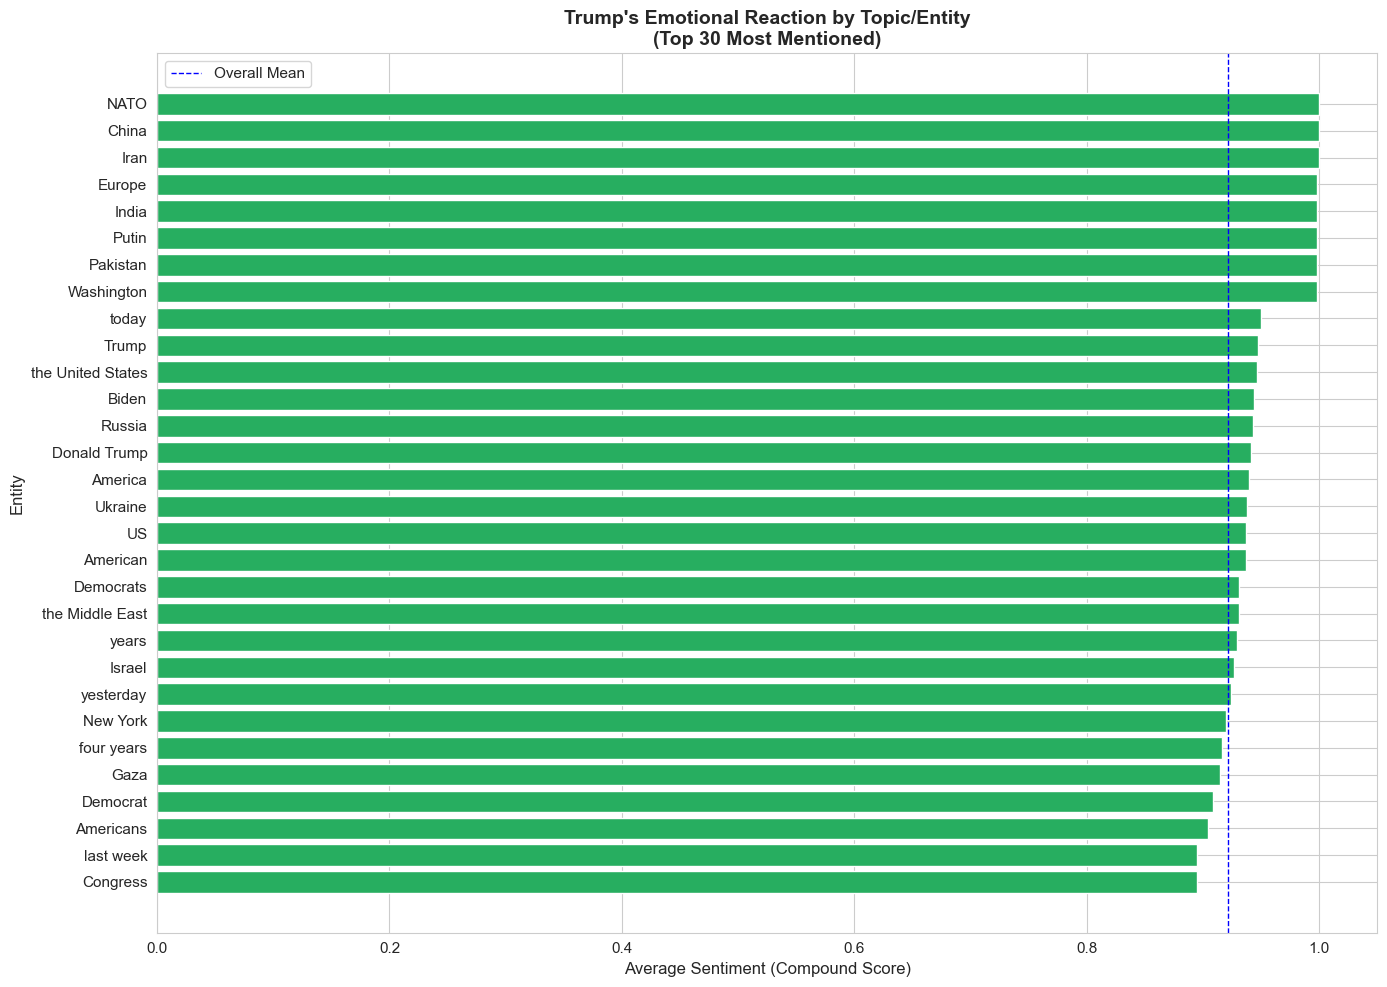

Saved: documentation/diagrams/entity_sentiment_reactions.png


In [16]:
# Plot: Sentiment by Entity (Top entities by frequency)
fig, ax = plt.subplots(figsize=(14, 10))

# Sort by sentiment - get top 30 most frequent entities
df_plot = df_reliable.nlargest(30, 'speech_count').sort_values('avg_sentiment')

# Color by sentiment (red = negative, green = positive)
colors = ['#e74c3c' if x < 0 else '#27ae60' if x > 0.5 else '#f39c12' for x in df_plot['avg_sentiment']]

bars = ax.barh(df_plot['entity_name'], df_plot['avg_sentiment'], color=colors)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(x=df_reliable['avg_sentiment'].mean(), color='blue', linestyle='--', linewidth=1, label='Overall Mean')

ax.set_xlabel('Average Sentiment (Compound Score)', fontsize=12)
ax.set_ylabel('Entity', fontsize=12)
ax.set_title("Trump's Emotional Reaction by Topic/Entity\n(Top 30 Most Mentioned)", fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig('../documentation/diagrams/entity_sentiment_reactions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: documentation/diagrams/entity_sentiment_reactions.png")


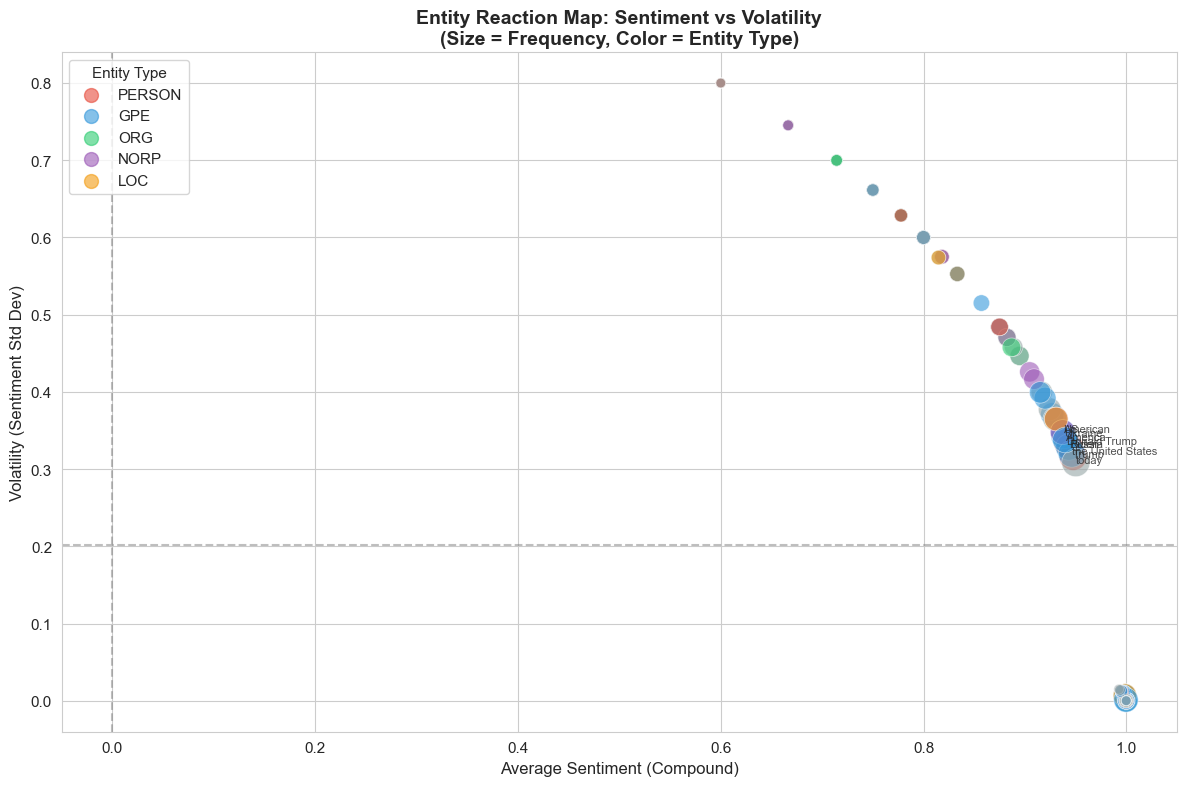

Saved: documentation/diagrams/entity_sentiment_volatility.png


In [17]:
# Plot: Sentiment vs Volatility Scatter
fig, ax = plt.subplots(figsize=(12, 8))

# Only plot entities with enough data
df_scatter = df_reliable[df_reliable['speech_count'] >= 5].copy()

# Size by speech count
sizes = df_scatter['speech_count'] * 10

# Color by entity type
type_colors = {'PERSON': '#e74c3c', 'GPE': '#3498db', 'ORG': '#2ecc71', 
               'NORP': '#9b59b6', 'LOC': '#f39c12', 'DATE': '#95a5a6'}
colors = [type_colors.get(t, '#7f8c8d') for t in df_scatter['entity_type']]

scatter = ax.scatter(df_scatter['avg_sentiment'], df_scatter['volatility'], 
                     s=sizes, c=colors, alpha=0.6, edgecolors='white', linewidth=0.5)

# Annotate top entities
for idx, row in df_scatter.nlargest(10, 'speech_count').iterrows():
    ax.annotate(row['entity_name'], (row['avg_sentiment'], row['volatility']),
                fontsize=8, alpha=0.8)

ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=df_scatter['volatility'].mean(), color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel('Average Sentiment (Compound)', fontsize=12)
ax.set_ylabel('Volatility (Sentiment Std Dev)', fontsize=12)
ax.set_title('Entity Reaction Map: Sentiment vs Volatility\n(Size = Frequency, Color = Entity Type)', fontsize=14, fontweight='bold')

# Legend for entity types
for etype, color in list(type_colors.items())[:5]:
    ax.scatter([], [], c=color, s=100, label=etype, alpha=0.6)
ax.legend(loc='upper left', title='Entity Type')

plt.tight_layout()
plt.savefig('../documentation/diagrams/entity_sentiment_volatility.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: documentation/diagrams/entity_sentiment_volatility.png")


## 6. Reaction Type Classification


In [18]:
# Classify entities into reaction types using CENTERED sentiment AND emotion scores
def classify_reaction(row):
    """Classify entity into a reaction type based on centered sentiment and actual emotion scores."""
    # Use CENTERED sentiment (relative to Trump's baseline)
    sentiment = row.get('centered_sentiment', row['avg_sentiment'] - GLOBAL_SENTIMENT_BASELINE)
    volatility = row['volatility']
    dominant_emotion = row.get('dominant_emotion', 'unknown')
    
    # Get actual negative emotion scores (not just dominant emotion)
    anger_score = row.get('avg_anger', 0)
    fear_score = row.get('avg_fear', 0)
    disgust_score = row.get('avg_disgust', 0)
    sadness_score = row.get('avg_sadness', 0)
    
    # Get positive emotion scores
    joy_score = row.get('avg_joy', 0)
    trust_score = row.get('avg_trust', 0)
    
    # Total negative vs positive emotion intensity
    negative_intensity = anger_score + fear_score + disgust_score + sadness_score
    positive_intensity = joy_score + trust_score
    
    # Compute emotion ratio (negative / total) - higher means more negative context
    total_intensity = negative_intensity + positive_intensity
    emotion_ratio = negative_intensity / total_intensity if total_intensity > 0 else 0.5
    
    # HIGH NEGATIVE EMOTION RATIO (>40% negative) OR below average sentiment
    if emotion_ratio > 0.4 or sentiment < -0.03:
        if volatility > 0.15:
            return 'ATTACK_MODE'  # High negative emotions + erratic
        else:
            return 'CRITICISM_MODE'  # High negative emotions, consistent
    
    # HIGH POSITIVE RATIO and above average sentiment
    elif sentiment > 0.03 and emotion_ratio < 0.3:
        if dominant_emotion in ['joy', 'trust'] or joy_score > 8:
            return 'CELEBRATION_MODE'  # Very positive
        else:
            return 'ACHIEVEMENT_MODE'  # Positive but focused
    
    # HIGH VOLATILITY regardless of sentiment
    elif volatility > 0.15:
        return 'UNPREDICTABLE'  # High variance in reactions
    
    # NEUTRAL ZONE
    else:
        if trust_score > 6:
            return 'DIPLOMATIC_MODE'
        elif dominant_emotion == 'anticipation':
            return 'NEGOTIATION_MODE'
        else:
            return 'NEUTRAL_MODE'

# Apply classification
df_reliable['reaction_type'] = df_reliable.apply(classify_reaction, axis=1)

# Show distribution
print("Reaction Type Distribution:")
print(df_reliable['reaction_type'].value_counts())


Reaction Type Distribution:
reaction_type
CELEBRATION_MODE    166
DIPLOMATIC_MODE     146
ATTACK_MODE          99
NEGOTIATION_MODE     58
UNPREDICTABLE        35
CRITICISM_MODE       16
ACHIEVEMENT_MODE     11
NEUTRAL_MODE          4
Name: count, dtype: int64


In [19]:
# Show examples of each reaction type
print("\n" + "=" * 60)
print("EXAMPLES BY REACTION TYPE")
print("=" * 60)

for reaction_type in df_reliable['reaction_type'].unique():
    print(f"\n🔹 {reaction_type}:")
    examples = df_reliable[df_reliable['reaction_type'] == reaction_type].nlargest(5, 'speech_count')
    for _, row in examples.iterrows():
        centered = row.get('centered_sentiment', row['avg_sentiment'] - GLOBAL_SENTIMENT_BASELINE)
        print(f"   - {row['entity_name']} ({row['entity_type']}) | Centered: {centered:+.3f} | Speeches: {row['speech_count']}")



EXAMPLES BY REACTION TYPE

🔹 UNPREDICTABLE:
   - today (DATE) | Centered: +0.075 | Speeches: 41
   - Trump (PERSON) | Centered: +0.072 | Speeches: 39
   - the United States (GPE) | Centered: +0.071 | Speeches: 38
   - Biden (PERSON) | Centered: +0.069 | Speeches: 36
   - Russia (GPE) | Centered: +0.068 | Speeches: 36

🔹 NEGOTIATION_MODE:
   - Putin (PERSON) | Centered: +0.123 | Speeches: 28
   - Pakistan (GPE) | Centered: +0.123 | Speeches: 25
   - Russian (NORP) | Centered: +0.125 | Speeches: 18
   - Congo (GPE) | Centered: +0.122 | Speeches: 15
   - the Oval Office (FAC) | Centered: +0.122 | Speeches: 14

🔹 DIPLOMATIC_MODE:
   - Iran (GPE) | Centered: +0.124 | Speeches: 31
   - China (GPE) | Centered: +0.125 | Speeches: 28
   - Europe (LOC) | Centered: +0.123 | Speeches: 28
   - India (GPE) | Centered: +0.123 | Speeches: 27
   - NATO (ORG) | Centered: +0.125 | Speeches: 24

🔹 CELEBRATION_MODE:
   - American (NORP) | Centered: +0.062 | Speeches: 32
   - Washington (GPE) | Centered: +

## 7. Reaction Predictor Function

**This is the core predictive model** - input any topic and get Trump's predicted reaction!


In [20]:
def predict_trump_reaction(entity_name, df_profiles):
    """
    🎯 PREDICTIVE MODEL: Predict Trump's likely reaction to a given entity/topic.
    
    Uses emotion RATIOS (negative vs positive emotions) for more accurate prediction,
    combined with centered sentiment scores.
    """
    # Search for entity (case-insensitive)
    matches = df_profiles[df_profiles['entity_name'].str.lower() == entity_name.lower()]
    
    if len(matches) == 0:
        # Try partial match
        matches = df_profiles[df_profiles['entity_name'].str.lower().str.contains(entity_name.lower(), na=False)]
    
    if len(matches) == 0:
        return {
            'entity': entity_name,
            'status': 'NOT_FOUND',
            'message': f"No data found for '{entity_name}'. Try a different spelling or related term."
        }
    
    # Use the most frequent match
    match = matches.nlargest(1, 'speech_count').iloc[0]
    
    # --- SENTIMENT CALCULATION (centered) ---
    raw_sentiment = float(match['avg_sentiment'])
    centered_sentiment = raw_sentiment - GLOBAL_SENTIMENT_BASELINE
    sentiment_score = round(centered_sentiment, 3)
    
    # --- EMOTION CALCULATION (use ratios, not just dominant) ---
    anger = float(match.get('avg_anger', 0))
    fear = float(match.get('avg_fear', 0))
    disgust = float(match.get('avg_disgust', 0))
    sadness = float(match.get('avg_sadness', 0))
    joy = float(match.get('avg_joy', 0))
    trust = float(match.get('avg_trust', 0))
    anticipation = float(match.get('avg_anticipation', 0))
    
    negative_intensity = anger + fear + disgust + sadness
    positive_intensity = joy + trust
    total_intensity = negative_intensity + positive_intensity
    
    # Emotion ratio: higher = more negative context
    emotion_ratio = negative_intensity / total_intensity if total_intensity > 0 else 0.5
    
    # Find actual dominant emotion by value
    emotion_scores = {
        'anger': anger, 'fear': fear, 'disgust': disgust, 'sadness': sadness,
        'joy': joy, 'trust': trust, 'anticipation': anticipation
    }
    dominant_emotion = max(emotion_scores, key=emotion_scores.get)
    emotion_score = emotion_scores[dominant_emotion]
    
    # --- DETERMINE SENTIMENT LABEL ---
    # High negative emotion ratio (>35%) OR clearly below average sentiment → NEGATIVE
    if emotion_ratio > 0.35 or centered_sentiment < -0.03:
        sentiment_label = 'NEGATIVE'
    # Low negative ratio AND above average sentiment → POSITIVE
    elif emotion_ratio < 0.30 and centered_sentiment > 0.03:
        sentiment_label = 'POSITIVE'
    else:
        sentiment_label = 'NEUTRAL'
    
    # --- DETERMINE REACTION TYPE ---
    volatility = float(match['volatility'])
    if sentiment_label == 'NEGATIVE':
        reaction_type = 'ATTACK_MODE' if volatility > 0.15 else 'CRITICISM_MODE'
    elif sentiment_label == 'POSITIVE':
        reaction_type = 'CELEBRATION_MODE' if dominant_emotion in ['joy', 'trust'] else 'ACHIEVEMENT_MODE'
    elif volatility > 0.15:
        reaction_type = 'UNPREDICTABLE'
    else:
        reaction_type = 'NEUTRAL_MODE'
    
    # Build prediction
    prediction = {
        'entity': match['entity_name'],
        'entity_type': match['entity_type'],
        'status': 'FOUND',
        'data_quality': f"Based on {match['speech_count']} speeches",
        
        # Sentiment (centered)
        'raw_sentiment': round(raw_sentiment, 3),
        'centered_sentiment': sentiment_score,
        'sentiment_label': sentiment_label,
        
        # Emotions
        'emotion_ratio': round(emotion_ratio, 3),
        'negative_intensity': round(negative_intensity, 2),
        'positive_intensity': round(positive_intensity, 2),
        'dominant_emotion': dominant_emotion,
        'dominant_emotion_score': round(emotion_score, 2),
        
        # Volatility
        'volatility': round(volatility, 3),
        'volatility_label': 'HIGH' if volatility > 0.15 else 'LOW' if volatility < 0.05 else 'MEDIUM',
        
        # Reaction type
        'reaction_type': reaction_type,
    }
    
    # Build interpretation
    if sentiment_label == 'NEGATIVE':
        prediction['interpretation'] = (
            f"Trump tends to react NEGATIVELY to '{match['entity_name']}' "
            f"(negative emotion ratio: {emotion_ratio:.0%}, dominant: {dominant_emotion})."
        )
    elif sentiment_label == 'POSITIVE':
        prediction['interpretation'] = (
            f"Trump tends to react POSITIVELY to '{match['entity_name']}' "
            f"(positive emotion ratio: {1-emotion_ratio:.0%}, dominant: {dominant_emotion})."
        )
    else:
        prediction['interpretation'] = (
            f"Trump has MIXED reactions to '{match['entity_name']}' "
            f"(emotion ratio: {emotion_ratio:.0%} negative, dominant: {dominant_emotion})."
        )
    
    if prediction['volatility_label'] == 'HIGH':
        prediction['interpretation'] += " Reactions are UNPREDICTABLE."
    
    return prediction

print("✓ Predictor function defined (with emotion ratios)!")


✓ Predictor function defined (with emotion ratios)!


In [21]:
# Test the predictor with various topics
print("=" * 70)
print("🎯 ENTITY REACTION PREDICTOR - TEST EXAMPLES")
print("=" * 70)

test_topics = ['China', 'Biden', 'America', 'Democrats', 'border', 
               'Russia', 'economy', 'NATO', 'media', 'Mexico']

for topic in test_topics:
    print(f"\n{'─' * 60}")
    result = predict_trump_reaction(topic, df_profiles)
    
    if result['status'] == 'FOUND':
        print(f"📌 TOPIC: {result['entity']} ({result['entity_type']})")
        print(f"   {result['data_quality']}")
        print(f"\n   🎯 PREDICTION:")
        print(f"      Centered Sentiment: {result['centered_sentiment']:+.3f} ({result['sentiment_label']})")
        print(f"      Emotion Ratio: {result['emotion_ratio']:.0%} negative | {1-result['emotion_ratio']:.0%} positive")
        print(f"      Dominant Emotion: {result['dominant_emotion']} (score: {result['dominant_emotion_score']:.1f})")
        print(f"      Volatility: {result['volatility']:.3f} ({result['volatility_label']})")
        print(f"      Reaction Type: {result['reaction_type']}")
        print(f"\n   📝 {result['interpretation']}")
    else:
        print(f"❌ {result['message']}")


🎯 ENTITY REACTION PREDICTOR - TEST EXAMPLES

────────────────────────────────────────────────────────────
📌 TOPIC: China (GPE)
   Based on 28 speeches

   🎯 PREDICTION:
      Centered Sentiment: +0.125 (NEUTRAL)
      Emotion Ratio: 30% negative | 70% positive
      Dominant Emotion: anticipation (score: 11.0)
      Volatility: 0.000 (LOW)
      Reaction Type: NEUTRAL_MODE

   📝 Trump has MIXED reactions to 'China' (emotion ratio: 30% negative, dominant: anticipation).

────────────────────────────────────────────────────────────
📌 TOPIC: Biden (PERSON)
   Based on 36 speeches

   🎯 PREDICTION:
      Centered Sentiment: +0.069 (NEUTRAL)
      Emotion Ratio: 32% negative | 68% positive
      Dominant Emotion: anticipation (score: 11.4)
      Volatility: 0.329 (HIGH)
      Reaction Type: UNPREDICTABLE

   📝 Trump has MIXED reactions to 'Biden' (emotion ratio: 32% negative, dominant: anticipation). Reactions are UNPREDICTABLE.

────────────────────────────────────────────────────────────


## 8. Save Results


In [22]:
# Save entity reaction profiles
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = Path('../data/results')
output_dir.mkdir(exist_ok=True)

# Save profiles as CSV
csv_path = output_dir / f'entity_reaction_profiles_{timestamp}.csv'
df_profiles.to_csv(csv_path, index=False)
print(f"✓ Saved profiles to: {csv_path}")

# Save as JSON with metadata
json_path = output_dir / f'entity_reaction_profiles_{timestamp}.json'
output_data = {
    'metadata': {
        'model': 'Entity Reaction Profiler (Model 1)',
        'generated_at': timestamp,
        'total_entities': len(df_profiles),
        'reliable_entities': len(df_reliable),
        'min_speeches_for_reliability': MIN_SPEECHES
    },
    'trigger_summary': {
        'top_negative_triggers': negative_triggers['entity_name'].tolist(),
        'top_positive_triggers': positive_triggers['entity_name'].tolist(),
        'high_volatility_triggers': volatility_triggers['entity_name'].tolist()
    },
    'profiles': df_profiles.to_dict('records')
}

with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(output_data, f, indent=2, default=str)
print(f"✓ Saved full data to: {json_path}")


✓ Saved profiles to: ..\data\results\entity_reaction_profiles_20251224_141047.csv
✓ Saved full data to: ..\data\results\entity_reaction_profiles_20251224_141047.json


## Summary

**Model 1: Entity Reaction Profiler** is complete!

### What this model does:
1. **Builds reaction profiles** for each entity (person, organization, country, etc.) mentioned in Trump's speeches
2. **Tracks emotional patterns** - sentiment, dominant emotions, rhetorical intensity
3. **Identifies triggers** - negative triggers, positive triggers, and volatile topics
4. **Classifies reaction types** - ATTACK_MODE, CRITICISM_MODE, CELEBRATION_MODE, etc.
5. **Predicts reactions** - input any topic → get predicted sentiment, emotion, and interpretation

### Key outputs:
- `entity_reaction_profiles_*.csv` - Full dataset of entity profiles
- `entity_reaction_profiles_*.json` - JSON with metadata and trigger summary
- `entity_sentiment_reactions.png` - Bar chart of sentiment by entity
- `entity_sentiment_volatility.png` - Scatter plot of sentiment vs volatility

### Usage:
```python
# Predict Trump's reaction to any topic

```


In [23]:
prediction = predict_trump_reaction("NATO", df_profiles)
print(prediction['interpretation'])

Trump has MIXED reactions to 'NATO' (emotion ratio: 31% negative, dominant: anticipation).


In [24]:
test_topics = ['China', 'Biden', 'America', 'Democrats', 'border', 
               'Russia', 'economy', 'NATO', 'media', 'Mexico']

for topic in test_topics:
    result = predict_trump_reaction(topic, df_profiles)
    print(result)

{'entity': 'China', 'entity_type': 'GPE', 'status': 'FOUND', 'data_quality': 'Based on 28 speeches', 'raw_sentiment': 1.0, 'centered_sentiment': np.float64(0.125), 'sentiment_label': 'NEUTRAL', 'emotion_ratio': 0.303, 'negative_intensity': 7.19, 'positive_intensity': 16.53, 'dominant_emotion': 'anticipation', 'dominant_emotion_score': 10.99, 'volatility': 0.0, 'volatility_label': 'LOW', 'reaction_type': 'NEUTRAL_MODE', 'interpretation': "Trump has MIXED reactions to 'China' (emotion ratio: 30% negative, dominant: anticipation)."}
{'entity': 'Biden', 'entity_type': 'PERSON', 'status': 'FOUND', 'data_quality': 'Based on 36 speeches', 'raw_sentiment': 0.944, 'centered_sentiment': np.float64(0.069), 'sentiment_label': 'NEUTRAL', 'emotion_ratio': 0.316, 'negative_intensity': 7.06, 'positive_intensity': 15.26, 'dominant_emotion': 'anticipation', 'dominant_emotion_score': 11.4, 'volatility': 0.329, 'volatility_label': 'HIGH', 'reaction_type': 'UNPREDICTABLE', 'interpretation': "Trump has MIXE